<a href="https://colab.research.google.com/github/allissonst/analise-netflix-daily-top-10/blob/main/Analise_Dados_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import zconfint
import warnings

warnings.filterwarnings("ignore")

#lendo o dataframe da Netflix
netflix = pd.read_csv("netflix_daily_top_ten.csv")
print("tamanho do data base (linhas, colunas)", netflix.shape)

#renomeando colunas
netflix.rename(columns = {'As of':'as_of',
                          'Rank':'rank',
                          'Year to Date Rank':'year_to_date',
                          'Last Week Rank':'last_week_rank',
                          'Title':'title',
                          'Type':'type',
                          'Netflix Exclusive':'netflix_exclusive',
                          'Netflix Release Date':'netflix_release_date',
                          'Days In Top 10':'days_in_top_10',
                          'Viewership Score':'viewership_score'}, inplace = True)

#colocando o Not nos campos vazios representado o produto não exclusivo da Netflix
netflix['netflix_exclusive'] = netflix['netflix_exclusive'].fillna('Not')

netflix.head()



tamanho do data base (linhas, colunas) (7100, 10)


,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
0,2020-04-01,1,1,1,"Tiger King: Murder, Mayhem …",TV Show,Yes,"Mar 20, 2020",9,90
1,2020-04-01,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",5,45
2,2020-04-01,3,3,2,All American,TV Show,Not,"Mar 28, 2019",9,76
3,2020-04-01,4,4,-,Blood Father,Movie,Not,"Mar 26, 2020",5,30
4,2020-04-01,5,5,4,The Platform,Movie,Yes,"Mar 20, 2020",9,55


In [ ]:
#deixando apenas os últimos registros dos produtos, pois os dados são acumulativos
netflix = netflix.drop_duplicates(
  subset = ['title'],
  keep = 'last').reset_index(drop = True)

In [ ]:
#estatísticas descritivas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
netflix.describe().round(2)[['days_in_top_10','viewership_score']]

,days_in_top_10,viewership_score
count,645.00,645.00
mean,11.18,61.75
std,19.99,97.75
min,1.00,1.00
25%,4.00,15.00
50%,7.00,33.00
75%,12.00,68.00
max,428.00,1474.00


Text(0.5, 1.0, 'Pontuação de audiência dos produtos hospedados na Netflix')

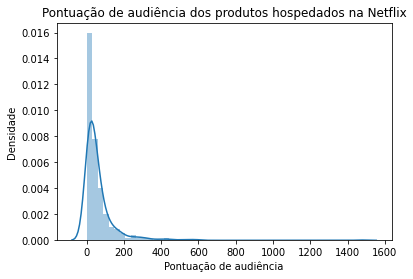

In [ ]:
ax = sns.distplot(netflix.viewership_score)
ax.set(xlabel='Pontuação de audiência', ylabel='Densidade')
ax.set_title('Pontuação de audiência dos produtos hospedados na Netflix')

Text(0.5, 1.0, 'Pontuação de audiência dos produtos hospedados na Netflix')

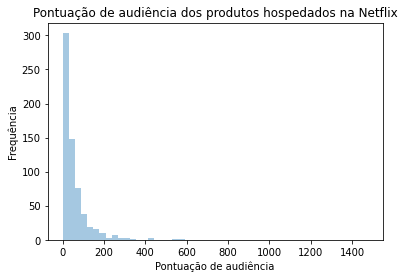

In [ ]:
ax = sns.distplot(netflix.viewership_score, norm_hist= False, kde= False)
ax.set(xlabel='Pontuação de audiência', ylabel='Frequência')
ax.set_title('Pontuação de audiência dos produtos hospedados na Netflix')

Text(0.5, 1.0, 'Nota da pontuação de audiência de produtos hospedados na Netflix')

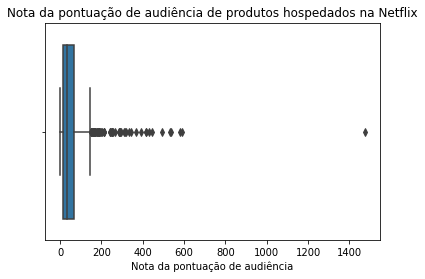

In [ ]:
#mostrando o bloxpot
ax = sns.boxplot(netflix.viewership_score)
ax.set(xlabel='Nota da pontuação de audiência')
ax.set_title('Nota da pontuação de audiência de produtos hospedados na Netflix')

Produtos com pontuação maior que 200 serão temporariamente eliminados das análises, pois visualmente podem representar outliers.

In [ ]:
netflix.query("viewership_score>200").head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
82,2020-07-05,10,10,4,365 Days,Movie,Yes,"Jul 7, 2020",28,213
141,2020-09-03,10,9,3,The Umbrella Academy,TV Show,Yes,"Feb 15, 2019",34,258
195,2020-10-30,9,8,1,Unsolved Mysteries,TV Show,Yes,"Jul 1, 2020",33,241
261,2021-01-06,10,9,6,The Queenâs Gambit,TV Show,Yes,"Oct 23, 2020",73,446
297,2021-02-21,10,10,8,Bridgerton,TV Show,Yes,"Dec 25, 2020",58,432


In [ ]:
netflix_com_pontuacao_menor_200_pontos = netflix.query("viewership_score<200")
netflix_com_pontuacao_menor_200_pontos.describe()

,rank,days_in_top_10,viewership_score
count,610.00,610.00,610.00
mean,8.75,8.43,44.33
std,1.42,6.25,41.64
min,1.00,1.00,1.00
25%,8.00,4.00,14.00
50%,9.00,7.00,31.00
75%,10.00,10.75,60.75
max,10.00,39.00,194.00


Text(0.5, 1.0, 'Distribuição da pontuação de audiência de produtos hospedados na Netflix, com pontuação menor que 200')

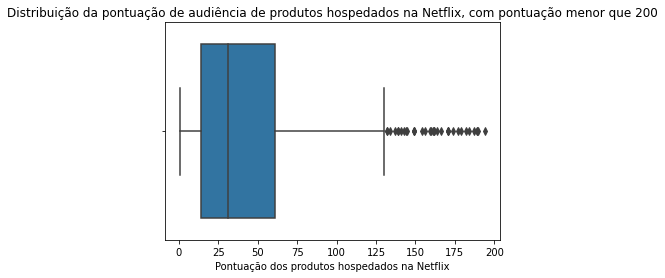

In [ ]:
ax = sns.boxplot(netflix_com_pontuacao_menor_200_pontos.viewership_score)
ax.set(xlabel='Pontuação dos produtos hospedados na Netflix')
ax.set_title('Distribuição da pontuação de audiência de produtos hospedados na Netflix, com pontuação menor que 200')

Text(0.5, 1.0, 'Distribuição da pontuação de audiência de produtos hospedados na Netflix, com pontuação menor que 200')

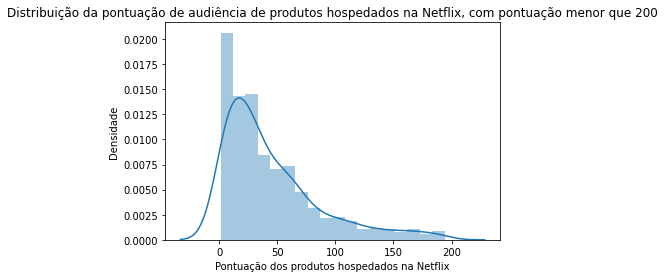

In [ ]:
ax = sns.distplot(netflix_com_pontuacao_menor_200_pontos.viewership_score)
ax.set(xlabel='Pontuação dos produtos hospedados na Netflix', ylabel='Densidade')
ax.set_title('Distribuição da pontuação de audiência de produtos hospedados na Netflix, com pontuação menor que 200')

**Analisando mais profundamente a pontuação dos produtos**

In [ ]:
#analisando a média da pontuação por tipo de produto hospedado na Netflix
pontuacao_media_por_tipo = netflix.groupby("type").mean()["viewership_score"]
pontuacao_media_por_tipo

type
Concert/Perf…     15.00
Movie             39.51
Stand-Up Comedy   38.00
TV Show           90.31
Name: viewership_score, dtype: float64

In [ ]:
#analisando a média da pontuação por produto exclusivo da Netflix (sim ou não)
pontuacao_media_por_exclusivo_netflix = netflix.groupby("netflix_exclusive").mean()["viewership_score"]
pontuacao_media_por_exclusivo_netflix 

netflix_exclusive
Not   49.04
Yes   69.09
Name: viewership_score, dtype: float64

# **Análise Cumulativa da pontuação do catálogo da Netflix**

Text(0.5, 1.0, 'Pontuação de audiência do catálogo da Netflix')

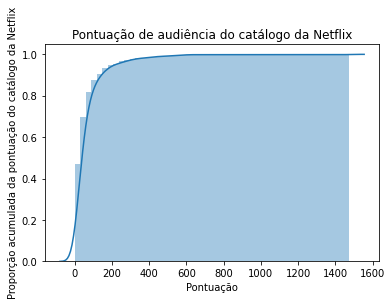

In [ ]:
ax = sns.distplot(netflix.viewership_score, 
                  hist_kws = {'cumulative':True}, 
                  kde_kws = {'cumulative':True})
ax.set(xlabel='Pontuação', ylabel='Proporção acumulada da pontuação do catálogo da Netflix')
ax.set_title('Pontuação de audiência do catálogo da Netflix')

Text(0.5, 1.0, 'Pontuação de audiência (<200) do catálogo da Netflix')

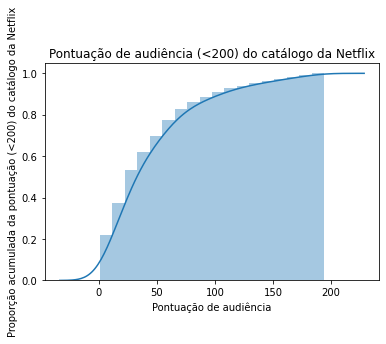

In [ ]:
ax = sns.distplot(netflix_com_pontuacao_menor_200_pontos.viewership_score, 
                  hist_kws = {'cumulative':True}, 
                  kde_kws = {'cumulative':True})
ax.set(xlabel='Pontuação de audiência', ylabel='Proporção acumulada da pontuação (<200) do catálogo da Netflix')
ax.set_title('Pontuação de audiência (<200) do catálogo da Netflix')

# Analisando outros campos do df netflix

Text(0.5, 1.0, 'Quantidade de dias dos produtos Netflix em top 10')

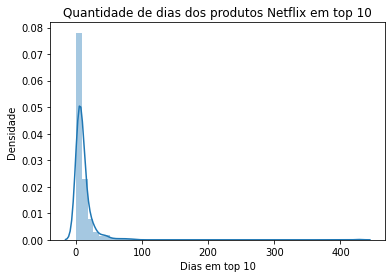

In [ ]:
ax = sns.distplot(netflix.query("days_in_top_10 > 0").days_in_top_10)
ax.set(xlabel='Dias em top 10', ylabel='Densidade')
ax.set_title('Quantidade de dias dos produtos Netflix em top 10')

Text(0.5, 1.0, 'Quantidade de dias dos produtos Netflix (pontuação<200) em top 10')

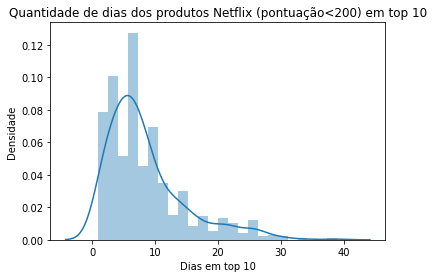

In [ ]:
ax = sns.distplot(netflix_com_pontuacao_menor_200_pontos.query("days_in_top_10 > 0").days_in_top_10)
ax.set(xlabel='Dias em top 10', ylabel='Densidade')
ax.set_title('Quantidade de dias dos produtos Netflix (pontuação<200) em top 10')

In [ ]:
print("Média da quantidade de vezes no ranking top 10:", round(netflix.viewership_score.mean()))

Média da quantidade de vezes no ranking top 10: 62


In [ ]:
#Média da pontuação considerando [0:a inclusão de novas observações]
medias = list()
for i in range(1, len(netflix.viewership_score)):
    medias.append(netflix.viewership_score[0:i].mean())
medias

[11.0,
 13.0,
 27.666666666666668,
 24.5,
 20.0,
 22.666666666666668,
 20.0,
 19.375,
 19.22222222222222,
 20.2,
 18.636363636363637,
 21.333333333333332,
 19.846153846153847,
 19.5,
 20.0,
 19.125,
 21.647058823529413,
 21.333333333333332,
 23.05263157894737,
 24.45,
 23.38095238095238,
 23.545454545454547,
 22.652173913043477,
 23.166666666666668,
 22.6,
 22.423076923076923,
 21.88888888888889,
 23.464285714285715,
 25.103448275862068,
 24.366666666666667,
 24.387096774193548,
 24.46875,
 24.242424242424242,
 25.352941176470587,
 25.34285714285714,
 25.5,
 27.43243243243243,
 27.526315789473685,
 26.846153846153847,
 27.1,
 28.390243902439025,
 28.214285714285715,
 27.906976744186046,
 28.40909090909091,
 28.266666666666666,
 27.847826086956523,
 27.617021276595743,
 27.4375,
 27.755102040816325,
 29.26,
 29.372549019607842,
 29.346153846153847,
 32.16981132075472,
 32.851851851851855,
 32.527272727272724,
 32.142857142857146,
 31.94736842105263,
 31.93103448275862,
 31.4915254237288

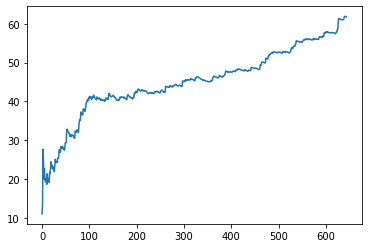

In [ ]:
#Gráfico considerando a média da pontuação [de 0:inclusão de novas observações]

medias = list()
for i in range(1, len(netflix.viewership_score)):
    medias.append(netflix.viewership_score[0:i].mean())
plt.plot(medias)

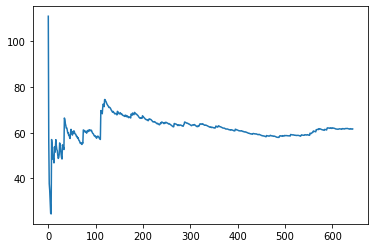

In [ ]:
#Gráfico considerando a média da pontuação [de 0:inclusão de novas observações] puxando aleatoriamente os valores
np.random.seed(75243)
temp = netflix.viewership_score.sample(frac=1)

medias = list()
medias = [temp[0:i].mean() for i in range(1, len(temp))]

plt.plot(medias)

In [ ]:
#intervalo de confiança para os valores da pontuação, considerando uma amostra grande
print(len(netflix))
zconfint(netflix.viewership_score)

645


(54.20696386220926, 69.29381133158918)

#**Vamos focar em analisar dois tipos agora:** 
##### 1 - TV Show (Séries)
##### 2 - Movie (Filmes)

In [ ]:
pontuacao_tv_show = netflix.query('type == "TV Show"')
pontuacao_movie = netflix.query('type == "Movie"')

In [ ]:
pontuacao_tv_show.head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
3,2020-04-02,10,6,-,Car Masters: Rust to Riches,TV Show,Yes,"Sep 14, 2018",5,15
7,2020-04-05,10,9,-,Unorthodox,TV Show,Yes,"Mar 26, 2020",6,15
9,2020-04-07,9,7,-,How to Fix a Drug Scandal,TV Show,Yes,"Apr 1, 2020",6,29
12,2020-04-12,10,-,-,Community,TV Show,Not,"Apr 1, 2020",2,2
13,2020-04-14,10,-,10,Legacies,TV Show,Not,"Apr 5, 2019",7,15


Text(0.5, 1.0, 'Pontuação de audiência para as séries')

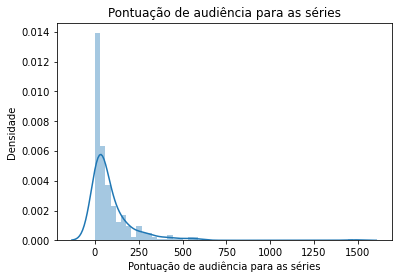

In [ ]:
ax = sns.distplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência para as séries', ylabel='Densidade')
ax.set_title('Pontuação de audiência para as séries')

Text(0.5, 1.0, 'Pontuação de audiência para as séries')

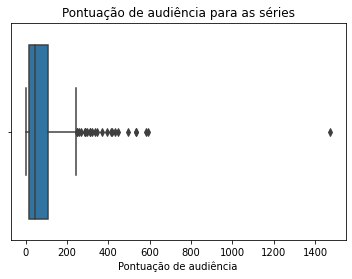

In [ ]:
ax = sns.boxplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência')
ax.set_title('Pontuação de audiência para as séries')

In [ ]:
#intervalo de confiança para as séries
zconfint(pontuacao_tv_show.viewership_score)

(74.38259997547424, 106.24637528954342)

In [ ]:
pontuacao_movie.head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
0,2020-04-01,9,8,-,Badland,Movie,Not,"Mar 26, 2020",4,11
1,2020-04-01,10,9,-,Uncorked,Movie,Yes,"Mar 27, 2020",4,15
2,2020-04-02,9,5,4,The Platform,Movie,Yes,"Mar 20, 2020",10,57
4,2020-04-03,9,-,-,Salt,Movie,Not,"Apr 1, 2020",1,2
5,2020-04-03,10,6,-,Blood Father,Movie,Not,"Mar 26, 2020",7,36


Text(0.5, 1.0, 'Pontuação de audiência para os filmes')

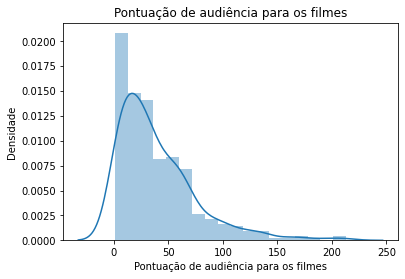

In [ ]:
ax = sns.distplot(pontuacao_movie.viewership_score)
ax.set(xlabel='Pontuação de audiência para os filmes', ylabel='Densidade')
ax.set_title('Pontuação de audiência para os filmes')

Text(0.5, 1.0, 'Pontuação de audiência para os filmes')

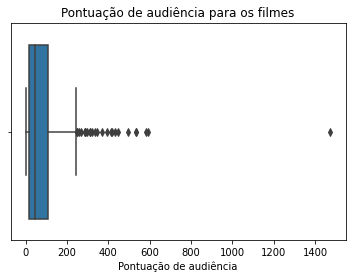

In [ ]:
ax = sns.boxplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência')
ax.set_title('Pontuação de audiência para os filmes')

In [ ]:
#intervalo de confiança para as séries
zconfint(pontuacao_tv_show.viewership_score)

(74.38259997547424, 106.24637528954342)

#**Comparação de dois conjuntos da amostra**

In [ ]:
print (ztest(pontuacao_tv_show.viewership_score, netflix.viewership_score))
zconfint(pontuacao_tv_show.viewership_score, netflix.viewership_score)
#A hipótese nula de que não há diferença na média é rejeitada

(3.606404583565531, 0.0003104689463261255)


(13.040437611344384, 44.087762459874824)

Text(0.5, 1.0, 'Distribuição das notas de acordo com os produtos')

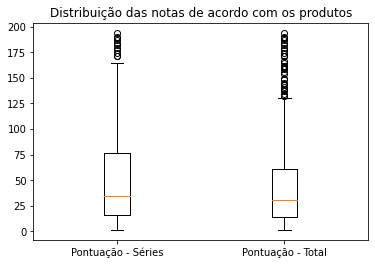

In [ ]:
#plotando bloxpot para os dois tipos de produto Netflix (pontuação < 200)
plt.boxplot([(pontuacao_tv_show.query('viewership_score<200').viewership_score), (netflix.query('viewership_score<200').viewership_score)], labels=["Pontuação - Séries", "Pontuação - Total"])
plt.title("Distribuição das notas de acordo com os produtos")

In [ ]:
print (ztest(pontuacao_tv_show.viewership_score, pontuacao_movie.viewership_score))
zconfint(pontuacao_tv_show.viewership_score, pontuacao_movie.viewership_score)
#A hipótese nula de que não há diferença na média é rejeitada

(6.71327444052813, 1.90304700124484e-11)


(35.970044765390504, 65.63357838695109)

Text(0.5, 1.0, 'Distribuição das notas de acordo com os produtos')

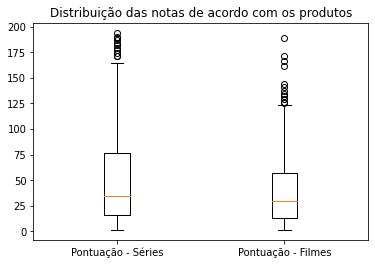

In [ ]:
#plotando bloxpot para os dois tipos de produto Netflix (pontuação < 200)
plt.boxplot([(pontuacao_tv_show.query('viewership_score<200').viewership_score), (pontuacao_movie.query('viewership_score<200').viewership_score)], labels=["Pontuação - Séries", "Pontuação - Filmes"])
plt.title("Distribuição das notas de acordo com os produtos")